# Zanesení bibliografických dat do bipartitního grafu

V tomto notebooku budeme pracovat s Bibliografií českého literárního exilu, která obsahuje záznamy o knihách a statích s literární tématikou, vydaných a publikovaných v českých exilových nakladatelstvích a časopisech. Nás budou zajímat pouze záznamy o statích, u kterých jsou uvedeni autor a časopis, ve kterém stať vyšla. Ty najdeme v polích `100 $a` (respektive `100 $7`) a `773 $t`. Notebook lze použít na všechny bibliografie. <br>
Ukážeme si, jak z dat získat jméno časopisu, jak data o autorech a časopisech následně zpracovat. Nakonec z nich vytvoříme strukturu bipartitního grafu, kterou vykreslíme pomocí knihovny `matplotlib`.   <br>
Tento notebook je určený jak pro začátečníky, tak pro ty, kteří se chtějí seznámit se zpracováním dat v Pythonu.

## Předpoklady

Tento notebook nepředpokládá hluboké znalosti Pythonu, ale základní znalost programování bude užitečná.<br> 

## Struktura notebooku

Notebook je rozdělen do několika částí:

0. **Příprava**: Přidáme potřebné knihovny, které budeme používat ke zpracování marcového souboru. 

1. **Načtení z CSV**: Ukážeme si, jak načíst naše data uložená v CSV.

2. **Extrahování a čištění dat**: Data z jednotlivých sloupců vyextrahujeme a očistíme.

3. **Zpracování**: Z našich očištěných dat získáme nejčastější autory a časopisy, do kterých přispívali. 

4. **Vytvoření struktury grafu**: Ukážeme si, jak pomocí knihovny networkx vytvoříme strukturu grafu, jak so ní přidáme uzle a hrany. Nakonec ji vykreslíme.

## Další zdroje

- [LearnPython.org](https://www.learnpython.org/): Tento online kurz nabízí výuku jazyka Python pro začátečníky i pokročilé. Může být užitečným zdrojem pro ty, kteří chtějí rozšířit své znalosti Pythonu.
- [W3Schools.com/Python](https://www.w3schools.com/python/): Obsáhlý tutoriál, který provází i některými oblíbenými knihovnamy Pythonu. 


### 0. Příprava 
Jako první si musíme nainstalovat knihovny, se kterými budeme pracovat. Knihovny jsou balíčky funkcí, které nejsou součástí základu jazyka python. <br>
Knihovny nainstalujeme pomocí příkazu `%pip install <jmeno_knihovny>` . Pak je do našeho notebooku přidáme pomocí příkazu `import <jmeno_knihovny> (as alias)`. K funkcím knihovny se pak přistupuje `jmeno_knihovny.jmeno_funkce` <br> 
Pokud z knihovny chceme využít pouze jednu funkci, přidáme ji pomocí `from <jmeno_knihovny> import <jmeno_funkce>`

In [83]:
%pip install matplotlib
%pip install networkx
%pip install numpy
%pip install pandas

from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Načtení z CSV

Nejprve pomocí knihovny pandas načteme naše uložená CSV data do datové struktury DataFrame (která je podobná např. excelovské tabulce). Řádky v DataFramu reprezentují jednotlivé záznamy, sloupce pak jeden typ (např. jmeno autora).
Některá pole a podpole mohou opakovat, ty jsou  v CSV spojené středníkem. V DataFramu pak funkcí `split()` hodnoty rozpojíme a převede do listu (seznamu). Pokud zrovna na daném místě žádná hodnota není, přidáme prázdný list.

In [84]:
# Cesta k nasim datum
csv_data = 'data/csv/out_cle.csv'

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')

print("Data načtena do DataFramu df.")

for column in df.columns:
    # u roku vydani vime, ze bude vzdy jen jedenkrat 
    if column != 'year':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


Data načtena do DataFramu df.


Podíváme, jak naše data v tabulce vypadají. Nejprve si vypíšeme, kolik záznamů obsahuje informaci o časopisu. To jsou záznamy o statích, které nás budou zajímat. Zbylé budeme považvat za záznamy o knihách. Pak si vypíšeme prvních 5 a posledních 5 položek v DataFramu. <br>

Nejprve si pomocí lambda funkce najdeme řádky, které obsahují informaci o časopisu. K nim přiřadíme 1 a všechny sečteme. Tím získáme celkový počet záznamů o statích. <br>
Od celkového počtu záznamů pak počet záznamů o statích odečteme, čímž získáme počet záznamů o knihách. Do našeho DataFramu `df` si nakonec uložíme jen záznamy o statích. 

###### Pokud bychom chtěli přesná data, v marcovém záznamu je kolonka LDR (leader), která nese informaci o typu záznamu. 

In [85]:
# Spocteme radky, ktere v maji nejakou  hodnotu
magazines_counts = df['magazine'].apply(lambda x: 1 if len(x) > 0 else 0)

sum_magazines_counts = magazines_counts.sum()

print("Počet záznamů o statích: ", sum_magazines_counts)

sum_books_counts = len(df) - sum_magazines_counts

print("Počet záznamů o knihách: ", sum_books_counts)

# Upravime si nas DataFrame tak, aby obsahoval jen zaznamy o statich
df = df[df['magazine'].apply(lambda x: len(x) > 0)]

Počet záznamů o statích:  7953
Počet záznamů o knihách:  1659


In [86]:
# Vypise prvnich 5 zaznamu v DataFramu
df.head()

,title,author,author code,year,figures,description,genre,magazine
0,[Kultura je když...],"[Kliment, Alexandr]",[jk01060558],1978,[],[estetika],[úvahy],[Spektrum]
1,[Hra o život],"[Dobrovský, Luboš]",[jn20000400479],1978,"[Kundera, Milan]",[česká próza],[studie],[Spektrum]
2,[Památce Bohuslava Reynka],"[Jirousová, Věra]",[jn19990218035],1978,"[Reynek, Bohuslav]",[čeští spisovatelé],[studie],[Spektrum]
3,[Joyceův zkušební návrat],"[Urbánek, Zdeněk]",[jk01140872],1978,"[Joyce, James]",[anglicky psané drama],[studie],[Spektrum]
4,[Čas jako trvání a jako prázdnota],"[Černý, Václav]",[jk01021636],1979,[],[estetika],[eseje],[Spektrum]


In [87]:
# Vypise poslednich 5 zaznamu v DataFramu
df.tail()

,title,author,author code,year,figures,description,genre,magazine
9607,[Co sklízet?],"[Odložilík, Otakar]",[jk01090958],1953,[],"[exilový tisk, exilová literatura, časopisecké...",[úvahy],[Sklizeň (Hamburg)]
9608,"[Viktor Dyk, rytíř národní cti a básník národn...","[Beran, Jan]",[],1957,"[Dyk, Viktor]","[čeští spisovatelé, čeští básníci, čeští drama...","[biografické poznámky, úryvky, česká dramata, ...",[Modrá revue (Rotterdam)]
9609,[České jméno ve světě],[],[],1960,"[Papini, Giovanni, Nosco, Beatrice M., Němeček...","[česká literatura, literárněvědné rozbory, rec...","[recenze, přehledy]",[Studie (Řím)]
9610,[[Television Opera Theatre...].],[],[],1953,"[Martinů, Bohuslav, Gogol‘, Nikolaj Vasil‘jevič]","[opery, libreta, hudební skladatelé, ruští spi...",[zprávy],[Sklizeň (Hamburg)]
9611,[Být sovětským básníkem],"[Vlach, Robert]",[jk01150030],1962,"[Ošanin, Lev Ivanovič, Jesenin, Sergej Aleksan...","[ruská poezie, ruští básníci, literatura a ide...","[úvahy, ruská poezie, úryvky]",[Studie (Řím)]


Jak můžeme vidět, většina záznamů má autora s přiřazeným kódem, nicméně např. záznam 9608 má autora bez kódu. Nás budou zajímat jen autoři s přiřazeným kódem.  

Abychom nemuseli psát stejný kód několikrát, napíšeme ho jednou do funkce, kterou pak jednoduše zavoláme. V tomto případě si napíšeme funkci, která nám z několika listů vnořených do sebe vytvoří jeden. To se nám bude hodit, až budeme chtít spočítat četnost. 

In [88]:
# Funkce na "zplosteni" nekolika vnorenych listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    if strings is not None: # Zkontrolujeme, jestli element neni None
        for item in strings:
            if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
                flattened_list.append(item)
            elif isinstance(item, list):  # Rekurzivne zavola sebe
                flattened_list.extend(flatten_list(item))
        return flattened_list

print("Funkce uložena")        

Funkce uložena


### 2. Extrahování a čištění dat

K časopisu je zpravidla připsáno i místo vydání. Pro naše účely nám stačí ale jen název časopisu. Proto pomocí regulárního výrazu  odstraníme místo vydání, které je napsané v kulatých (v bibliografii českého literárního exilu cle), nebo hranatých závorkách (v bibliografii samizdatu).<br>

Nejprve si určíme regulární výraz, který nám najde string před závorkou. Pak ho pomocí lambda funkce najdeme u hodnot ve sloupci `magazine`. Některé hodnoty mají přebytečné mezery před a po stringu. Ty odstraníme pomocí funkce `strip()`. Nakonec všechny vnořené listy odstraníme pomocí napí funkce `flatten_list()`.

In [89]:
# regex patern, ktery najde substring pred zavorkou
# r"^(.*?)\s*(?=\()" <- kulate zavorky
pattern_magazine = r"^(.*?)\s*(?=\()"   #r"(.*?)\[" # <- hranate zavory  

# Odstranime misto vydani v zavore (pokud je pritomno)
df['magazine'] = df['magazine'].apply(lambda x: [re.search(pattern_magazine, y).group(1) if re.search(pattern_magazine, y) else y for y in x])

# Zbavime se prebytecnych mezer na zacatku a na konci stringu
df['magazine'] = df['magazine'].apply(lambda x: [y.strip() for y in x])

# Unikatni casopisy
unique_magazine = np.unique(flatten_list(df.magazine))
print("Počet časopisů v bibliografii je: " + str(len(unique_magazine)))
print("Všechny časopisy v databázi: \n",unique_magazine)



Počet časopisů v bibliografii je: 49
Všechny časopisy v databázi: 
 ['150 000 slov' 'Acta' 'Archa' 'Bohemia' 'Demokracia v exile'
 'Demokracie v exilu' 'Hlas exilu'
 'Information Service of Free Czechoslovakia'
 'Kalendář československého exilu'
 'Klub : informace Klubu čtenářů CCC Books' 'Listy' 'Magazín'
 'Modrá revue' 'Most a.t.d.' 'Naši v Holandsku' 'Nové obzory' 'Nový život'
 'Národní politika' 'Obrys' 'Okno dokořán' 'Paternoster' 'Perspektivy'
 'Premeny' 'Proměny' 'Právo lidu' 'Reportér' 'Rozmluvy' 'Sborník Bohemia'
 'Sklizeň' 'Sklizeň svobodné tvorby' 'Skutečnost' 'Spektrum' 'Spektrum :'
 'Studie' 'Svědectví' 'Telegram' 'Text' 'Zpravodaj'
 'Zpravodaj : sdružení čs. politických uprchlíků v Německu - Sdruženie čs. politických ubehlíkov v Německu'
 'Zvon' 'Západ' 'Zápisník' 'příl. Dokumentace Charty 77 1983'
 'příl. Knižní jídelníček' 'příl. časopisu Modrá revue'
 'Čechoslovák v zahraničí' 'Československý přehled' 'Česká příloha'
 'České slovo']


### 3. Zpracování

Abychom mohli vytvořit graf, musíme data v tabulce zpracovat. V grafu chceme zobrazit deset nejčetnějších autorů a k nim přiřadit časopisy, do kterých autoři přispívali. Příkladu vyselektujeme pouze autory, kteří mají přiřazený kód. Je to kvůli tomu, abychom odstranili nežádoucí záznamy, jako jsou například články, které psala celá redakce časopisu. Ty žádné kódy přiřazené nemají. V našem příkladu se zajímáme jen o konkrétní osoby. <br>    

#### 3.1 Nalezení 10 nejčastějších autorů

Nejprve musíme zjistit všechny autory, kteří se v bibliografii objevují. Pomocí funkce `Counter()` spočteme jejich četnosti a vybereme jen 10 nejčastějších.

In [90]:
author_column = 'author'

# Vsichni autori ve sloupci, kteri maji prirazenz kod
all_authors = flatten_list(df[df['author code'] != None][author_column])

# Spocteme, v kolika zaznamech se autor objevil
counted_authors = Counter(all_authors)

# Pocet uzlu, ktere chceme vykreslit
n = 10

# Najdeme nejcastejsi autory, ktere pak zobrazime
most_common_authors = [item[0] for item in counted_authors.most_common(n)]

print("Deset nejčastějších autorů: \n", most_common_authors)


Kódy deseti nejčastějších autorů: 
 ['Dresler, Jaroslav', 'Kratochvil, Antonín', 'Den, Petr', 'Měšťan, Antonín', 'Škvorecký, Josef', 'Kovtun, Jiří', 'Vlach, Robert', 'Želivan, Pavel', 'Řehoř, Pavel', 'Vladislav, Jan']


#### 3.2 Získání indexů nejčastějších autorů

U 10 nejčastějších autorů najdeme indexy řádků, ve kterých se autoři vyskytovali.  K tomu si napíšeme funkci `find_indices(df, column, most_common)`, která v DataFramu `df` najde indexy všech řádků, které mají alespoň jedno jméno z listu `most_common` ve sloupci `column`. <br> 

In [91]:
def find_indices(df, column, most_common):
    # Seznam indexu  
    ind = []
    
    # Prochazeni přes DataFrame df
    for _, row in df.iterrows():
        
        # Pokud neni list prazdny, zjistime, zda list neobsahuje element ze seznamu most_common 
        if len(row[column]) > 0 :
            
            # Pokud list obsahuje element ze seznamu most_common, pridame True. Jinak pridame False
            if any(author in row[column] for author in most_common):
                ind.append(True)
            else:
                ind.append(False)                        
        else:              
            ind.append(False)               
    return ind            

print("Funkce uložena.")    

Funkce uložena.


Zavoláme naši funkci `find_indices(df, column, most_common)` a zjistíme indexy všech řádků, kde se objevuje nějaký autor z `most_common_authors`. Pak si je vypíšeme.<br>
List indexů je list true/false hodnot, kde true hodnota znamená, že řádek autora obsahujea a false že neobsahuje.<br>
Pro zajímavost si vypíšeme i čísla řádků, kde se autor objevuje.  

In [92]:
# Zjistime indexy vsech radku, kde se objevuji autori, ktere chceme zobrazit   
ind = find_indices(df, author_column, most_common_authors)

# Alternativni zjisteni indexu v jednom radku
# [True if any([True if author in most_common_authors else False for author in author_list]) else False for author_list in df[author_code_column]]

print(ind)
print([i for i, x in enumerate(ind) if x])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, False, False, False, False, True, True, False, False, True, True, False, True, True, False, True, False, False, True, False, False, False, True, False, True, True, True, True, False, True, False, False, True, True, True, False, False, False, False, False, False, True, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, False, False, Tru

#### 3.3 Nalezení časopisů

Určíme si sloupec, který chceme přiřadit. V našem případě je to sloupec `magazine`. Pak už jen pomocí indexů zjistíme, do jakých časopisů nejčastější autoři publikovali.   

In [93]:
# Sloupec, ktery chceme zobrazit.
column =  'magazine'

# Vsechny casopisy v zaznamech, kde se objevuje autor z most_common_authors
author_elements = df[ind][column]

# Pouze unikatni jmena casopisu
unique_author_elements = np.unique(flatten_list(author_elements)) 

print("Všechny časopisy, do kterych 10 nejčastějších autorů přispívalo: \n", unique_author_elements)

Všechny časopisy, do kterych 10 nejčastějších autorů přispívalo: 
 ['150 000 slov' 'Acta' 'Archa' 'Bohemia' 'Demokracia v exile'
 'Demokracie v exilu' 'Hlas exilu' 'Listy' 'Magazín' 'Modrá revue'
 'Naši v Holandsku' 'Nové obzory' 'Nový život' 'Národní politika' 'Obrys'
 'Paternoster' 'Perspektivy' 'Premeny' 'Proměny' 'Právo lidu' 'Reportér'
 'Rozmluvy' 'Sklizeň' 'Sklizeň svobodné tvorby' 'Skutečnost' 'Studie'
 'Svědectví' 'Telegram' 'Text' 'Zpravodaj' 'Zvon' 'Západ' 'Zápisník'
 'příl. časopisu Modrá revue' 'Československý přehled' 'České slovo']


<div class='alert alert-block alert-info'>
    <b>Try It!</b> Pomocí toho kódu lze zobrazit i jiné vztahy dvou sloupců, např. kteří autoři psali o jakých osobnostech (figures). K tomu jen změníme údaj proměnné `column`
</div>

#### 3.4 Spočtení vah

Ke každé dvojici ('autor', 'časopis') zjistíme četnost. To uděláme tak. že si vytvoříme dictionary `edge_weights`, kde klíče budou tuples ('autor', 'časopis') a hodnoty počet napsaných článků daným autorem do časopisu. 

In [94]:
# Vahy hran. Cim vice clanku v casopisu, tim vyssi vaha.
# Ve vykreslenem grafu pak bude vyssi vaha mit silnejsi caru. 
edge_weights = {}

# Projdeme vsechny clanky
for _,row in df.iterrows():
    for element in row[column]:
        for author in row[author_column]:
            # Chceme vyselektovat jen desen nejcastejsich elementu a casopisu
            if element in unique_author_elements and author in most_common_authors:
                if  (author, element) in edge_weights:
                    # Do dictionary hrany pridavame jako tuple 
                    edge_weights[(author, element)] += 1
                else:
                    edge_weights[(author, element)] = 1
                    
edge_weights                   

{('Vladislav, Jan', 'Acta'): 4,
 ('Kratochvil, Antonín', 'Archa'): 28,
 ('Den, Petr', 'Archa'): 3,
 ('Dresler, Jaroslav', 'Archa'): 7,
 ('Želivan, Pavel', 'Archa'): 4,
 ('Kovtun, Jiří', 'Archa'): 3,
 ('Vlach, Robert', 'Bohemia'): 1,
 ('Dresler, Jaroslav', 'České slovo'): 106,
 ('Den, Petr', 'České slovo'): 12,
 ('Kratochvil, Antonín', 'České slovo'): 74,
 ('Želivan, Pavel', 'České slovo'): 2,
 ('Škvorecký, Josef', 'České slovo'): 1,
 ('Kovtun, Jiří', 'České slovo'): 1,
 ('Měšťan, Antonín', 'České slovo'): 1,
 ('Řehoř, Pavel', 'České slovo'): 1,
 ('Vlach, Robert', 'Československý přehled'): 1,
 ('Vlach, Robert', 'Demokracia v exile'): 1,
 ('Kratochvil, Antonín', 'Demokracie v exilu'): 2,
 ('Vlach, Robert', 'Demokracie v exilu'): 3,
 ('Vlach, Robert', 'Hlas exilu'): 1,
 ('Kratochvil, Antonín', 'Hlas exilu'): 10,
 ('Želivan, Pavel', 'Hlas exilu'): 3,
 ('Škvorecký, Josef', 'Listy'): 27,
 ('Měšťan, Antonín', 'Listy'): 1,
 ('Vladislav, Jan', 'Listy'): 12,
 ('Škvorecký, Josef', 'Magazín'): 3,

### 4. Vytvoření struktury grafu

V následujícím kroku vytvoříme graf, který nakonec vykreslíme. Využijeme k tomu knihovnu `networkx`, kam jen přidáme dvě sady uzlů - autory a časopisy, a k nim vážené hrany. Graf nakonec vykreslíme.     

#### 4.1 Vložení jedné sady uzlů

Nejprve vytvoříme objekt grafu `G` a vložíme do něj jména nejčastějších autorů jako uzle. 

In [95]:
# Vytvorime graf
G = nx.Graph()

# Elementy pridame grafu jako uzle
G.add_nodes_from(most_common_authors, bipartite=1)

G.nodes

NodeView(('Dresler, Jaroslav', 'Kratochvil, Antonín', 'Den, Petr', 'Měšťan, Antonín', 'Škvorecký, Josef', 'Kovtun, Jiří', 'Vlach, Robert', 'Želivan, Pavel', 'Řehoř, Pavel', 'Vladislav, Jan'))

#### 4.2 Vložení druhé sady uzlů a hran

Jak jsme mohli vidět výše, hran je opravdu mnoho. Abychom graf neměli přehlcený, omezíme počet vykreslených hran na ty nejčetnější. Parametrem `threshold` nastavíme, jaký je potřeba minimální počet článků od jednoho autora pro to, aby se časopis zobrazil. Do našeho grafu `G` pak přidáme uzle a hrany, se vejdou do omezení parametru `threshold`. 

In [96]:
# Vykreslime jen ty casopisy, ktere se objevuji vicekrat  
threshold = 15

# Casopisy, do kterych bylo napsano alespon <threshold> clanku od jednoho autora
left = []

# Prochazime hrany a pridavame je do grafu
for edge, weight in edge_weights.items():
    if weight>threshold:
        if ~G.has_node(edge[1]):
            left.append(edge[1])
            G.add_node(edge[1], bipartite=0) 
        G.add_edge(edge[0], edge[1], weight=weight)    

print("Struktura grafu vytvořena.")  
G.edges                  

Struktura grafu vytvořena.


EdgeView([('Dresler, Jaroslav', 'České slovo'), ('Dresler, Jaroslav', 'Národní politika'), ('Dresler, Jaroslav', 'Zvon'), ('Dresler, Jaroslav', 'Zápisník'), ('Kratochvil, Antonín', 'Archa'), ('Kratochvil, Antonín', 'České slovo'), ('Kratochvil, Antonín', 'Národní politika'), ('Kratochvil, Antonín', 'Nový život'), ('Kratochvil, Antonín', 'Proměny'), ('Kratochvil, Antonín', 'Studie'), ('Den, Petr', 'Nový život'), ('Den, Petr', 'Perspektivy'), ('Den, Petr', 'Proměny'), ('Den, Petr', 'Sklizeň'), ('Měšťan, Antonín', 'Právo lidu'), ('Měšťan, Antonín', 'Proměny'), ('Měšťan, Antonín', 'Reportér'), ('Měšťan, Antonín', 'Svědectví'), ('Škvorecký, Josef', 'Listy'), ('Škvorecký, Josef', 'Západ'), ('Kovtun, Jiří', 'Svědectví'), ('Vlach, Robert', 'Sklizeň'), ('Želivan, Pavel', 'Nový život'), ('Řehoř, Pavel', 'Zpravodaj'), ('Vladislav, Jan', 'Národní politika')])

#### 4.3 Vykreslení grafu

Teď už jen pomocí knihovny `matplotlib` graf vykreslíme. Nejprve si připravíme prázdné plátno, kam graf nakreslíme. Pak si určíme šířku hran. Nakonec graf pomocí funkce `draw_networkx()` vykreslíme. 

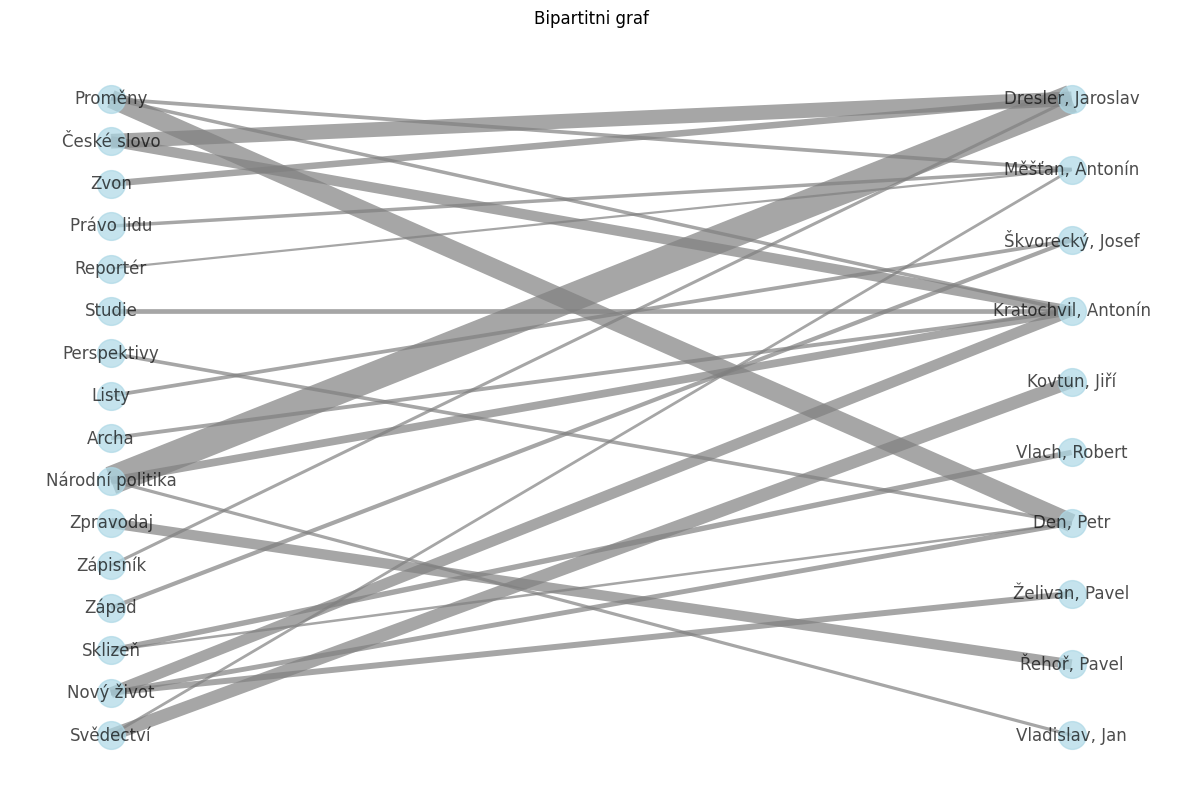

In [97]:
pos = nx.bipartite_layout(G, nodes = left)

# Vytvoreni prazdneho platna
plt.figure(figsize=(15, 10))

# Sirka hrany 
width = 0.1
edge_widths = [width * G[u][v]['weight'] for u, v in G.edges()]

# Vykresleni grafu
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', node_size=400,
                 width=edge_widths, edge_color='gray', alpha=0.7)
plt.title("Bipartitni graf")
plt.axis("off")
plt.savefig("plots/bipartite_graph.svg")
plt.show()

Na grafu vidíme, do kterých časopisů 10 nejčetnějších autorů psalo své příspěvky.<br> 
Zdaleka nejvíce článků napsal Jaroslav Dresler do časopisu Národní politika, pak do časopisu <i>České slovo</i>. Někteří autoři, jako např. Antonín Kratochvil neb Antonín Měšťan, nebyli spjati pouze s jedním časopisem a publikovali své články do vícero časopisů. Naopak Jiří Kovtun publikoval výhradně do časopisu <i>Svědectví</i>, Pavel Řehoř zase do periodika <i>Zpravodaj</i>.<br> 
Musíme mít na paměti, že časopisy jsou omezeny parametrem `threshold` pro čitelnější vykreslení. Pokud bychom chtěli vykreslit všechny časopisy, `threshold` nastavíme na 1. <br>

Například Josef Škvorecký, jak vidíme v následující buňce, napsal příspěvky do 14 časopisů, nicméně se nám v grafu zobrazují jen dva nejčastější –⁠ <i>Západ</i> a <i>Listy</i>. <br>

In [98]:
# Vsechny casopisy, do kterych J. Skvorecky psal
j_skvorecky_magazines = df[df['author'].apply(lambda x: any(author == 'Škvorecký, Josef' for author in x ))]['magazine']

# unikatni casopisy
unique_j_skvorecky_magazine = np.unique(flatten_list(j_skvorecky_magazines))

print("Josef Škvorecký přispíval do ",len(unique_j_skvorecky_magazine), " časopisů." )
print(unique_j_skvorecky_magazine)


Josef Škvorecký přispíval do  14  časopisů.
['150 000 slov' 'Listy' 'Magazín' 'Národní politika' 'Obrys' 'Proměny'
 'Právo lidu' 'Reportér' 'Studie' 'Svědectví' 'Telegram' 'Zpravodaj'
 'Západ' 'České slovo']


<div class='alert alert-block alert-info'>
    <b>Try It!</b>  Pomocí parametru threshold zkuste přidat nebo ubrat některé hrany. <br>
</div>

Bipartitní graf je dobrý nástroj pro zobrazovní vztahů mezi dvěma entitami. V tomto případě jsme zobrazili vztah mezi autory literárních statí a exilových časopisů, do kterých autoři publikovali. <br>

<div class='alert alert-block alert-info'>
    <b>Try It!</b>  Místo časopisů si můžeme zobrazit sloupec 'figures'. Graf nám pak ukáže, kteří autoři psali o kterých osobnostech. Nebo si můžeme zobrazit žánry, které autoři nejčastěji psali. Bibliografii také můžeme na začátku notebooku časově ohraničit.<br>
    Také se nemusíme omezovat na bibliografii českého literárního exilu. 
</div>